 a costum 3-d unet, training on ED, predicting ED

# Imports

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from torch.autograd import Variable
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
from scipy import ndimage as ndi
from skimage.transform import resize
from sklearn.externals._pilutil import bytescale
from skimage.filters import roberts
from skimage.measure import label,regionprops, perimeter, regionprops_table
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing, remove_small_holes
import pandas as pd
import os
import nibabel as nib


import matplotlib.pyplot as plt
%matplotlib inline

%gui qt

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Sat May  1 12:16:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:00:05.0 Off |                  N/A |
|  0%   24C    P0    55W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import Data

In [3]:
dataDir = 'downloads/OpenDataset/'
metadata = pd.read_csv(dataDir + '201014_M&Ms_Dataset_Information_-_opendataset.csv')
metadata

,External code,VendorName,Vendor,Centre,ED,ES
0,A0S9V9,Siemens,A,1,0,9
1,A1D0Q7,Philips,B,2,0,9
2,A1D9Z7,Siemens,A,1,22,11
3,A1E9Q1,Siemens,A,1,0,9
4,A1K2P5,Canon,D,5,33,11
...,...,...,...,...,...,...
340,T2Z1Z9,Canon,D,5,29,9
341,T9U9W2,Siemens,A,1,0,10
342,V4W8Z5,GE,C,4,19,9
343,W5Z4Z8,Philips,B,2,29,11


# Define Dataset

In [4]:
def normalize_01(inp: np.ndarray):
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def change_sizes(img, diff_seq, is_mask):
    img = img[:,:, diff_seq//2:img.shape[2]-(diff_seq-diff_seq//2)]
    res = []
    temp = np.zeros((200, 200))
    res.append(temp)
    for i in range(img.shape[2]):
        x = resize(img[:,:, i], (200,200))
        res.append(x)
    res.append(temp)
    return np.asarray(res)
    
def change_size_and_pad(img, diff_seq):
    res = []
    temp = np.zeros((200, 200))
    for i in range(diff_seq//2):
        res.append(temp)
    for i in range(img.shape[2]):
        x = resize(img[:,:, i], (200,200))
        res.append(x)
    for i in range(diff_seq - diff_seq//2):
        res.append(temp)
    return np.asarray(res)


class SegDataset(Dataset):
    def __init__(self, all_dirs, metadata, addr):
        self.all_dirs = all_dirs 
        self.metadata = metadata
        self.addr = addr
        self.num_seq = 10 

    def __len__(self):
        return 2*len(self.all_dirs)
    
    def __getitem__(self, idx):
        item = self.all_dirs[idx//2]
        path = self.addr + item

        mask, img, id = None, None, None

        ### lazy load data
        for root, dir, files in os.walk(path):
            for f in files:
                img_arr = nib.load(path + '/' + f).get_fdata()
#                 print(f"file name is {f}")
                if f[-8] == 't':
                    id = f.split('_')[0]
                    mask = img_arr
                else:
                    img = img_arr
        
        # preparing data 
#         print(f"df: {metadata[metadata['External code'] == id]['ES']}")
        if idx %2 == 0:
            t = metadata[metadata['External code'] == id]['ES'].iloc[0]
        else:
            t = metadata[metadata['External code'] == id]['ED'].iloc[0]
        
        img = img[:, :, :, t]
        gt = mask[:, :, :, t]


#         print('maximum number of mask', np.max(gt) , '\tmax of img', np.max(img))

        diff_seq = img.shape[2] - self.num_seq
        if diff_seq > 0: 
            img = change_sizes(img, diff_seq, False)
            gt = change_sizes(gt, diff_seq, True)
        else:
#             print(f'BEFORE shape of img is {img.shape} and shape of mask is {gt.shape}')
            img = change_size_and_pad(img, self.num_seq+2-img.shape[2])
            gt = change_size_and_pad(gt, self.num_seq+2-gt.shape[2])
#             print(f'AFTER shape of img is {img.shape} and shape of mask is {gt.shape}')

        img = normalize_01(img)
        
        
        # convert to tensors
        img = torch.FloatTensor([img])
        mask = torch.LongTensor(gt)

        return img, mask

# Load Dataset, DataLoader

In [5]:
batch_size = 4
num_epochs = 60
learning_rate = 0.01

In [6]:
train_dir = dataDir + '/Training/Labeled/'
train_all = os.listdir(train_dir)
train_dataset = SegDataset(train_all, metadata, train_dir)


val_dir = dataDir + '/Validation/'
val_all = os.listdir(val_dir)[:8]
val_dataset = SegDataset(val_all, metadata, val_dir)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# Define 3d unet
https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-model-building-6ab09d6a0862

In [7]:
@torch.jit.script
def autocrop(encoder_layer: torch.Tensor, decoder_layer: torch.Tensor):
    """
    Center-crops the encoder_layer to the size of the decoder_layer,
    so that merging (concatenation) between levels/blocks is possible.
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if encoder_layer.shape[2:] != decoder_layer.shape[2:]:
        ds = encoder_layer.shape[2:]
        es = decoder_layer.shape[2:]
        assert ds[0] >= es[0]
        assert ds[1] >= es[1]
        if encoder_layer.dim() == 4:  # 2D
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2)
                            ]
        elif encoder_layer.dim() == 5:  # 3D
            print('now I want to do cropping: encoder shape', encoder_layer.shape, '\t decoder shape', decoder_layer.shape)
            assert ds[2] >= es[2]
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2),
                            ((ds[2] - es[2]) // 2):((ds[2] + es[2]) // 2),
                            ]
            print('encoder layer shape at end', encoder_layer.shape)
    return encoder_layer, decoder_layer


def conv_layer(dim: int):
    if dim == 3:
        return nn.Conv3d
    elif dim == 2:
        return nn.Conv2d


def get_conv_layer(in_channels: int,
                   out_channels: int,
                   kernel_size: int = 3,
                   stride: int = 1,
                   padding: int = 2,
                   bias: bool = True,
                   dim: int = 2):
    return conv_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           bias=bias)


def conv_transpose_layer(dim: int):
    if dim == 3:
        return nn.ConvTranspose3d
    elif dim == 2:
        return nn.ConvTranspose2d


def get_up_layer(in_channels: int,
                 out_channels: int,
                 kernel_size: int = 2,
                 stride: int = 2,
                 dim: int = 3,
                 up_mode: str = 'transposed',
                 ):
    if up_mode == 'transposed':
        return conv_transpose_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
    else:
        return nn.Upsample(scale_factor=2.0, mode=up_mode)


def maxpool_layer(dim: int):
    if dim == 3:
        return nn.MaxPool3d
    elif dim == 2:
        return nn.MaxPool2d


def get_maxpool_layer(kernel_size: int = 2,
                      stride: int = 2,
                      padding: int = 0,
                      dim: int = 2):
    return maxpool_layer(dim=dim)(kernel_size=kernel_size, stride=stride, padding=padding)


def get_activation(activation: str):
    if activation == 'relu':
        return nn.ReLU()
    elif activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)
    elif activation == 'elu':
        return nn.ELU()


def get_normalization(normalization: str,
                      num_channels: int,
                      dim: int):
    if normalization == 'batch':
        if dim == 3:
            return nn.BatchNorm3d(num_channels)
        elif dim == 2:
            return nn.BatchNorm2d(num_channels)
    elif normalization == 'instance':
        if dim == 3:
            return nn.InstanceNorm3d(num_channels)
        elif dim == 2:
            return nn.InstanceNorm2d(num_channels)
    elif 'group' in normalization:
        num_groups = int(normalization.partition('group')[-1])  # get the group size from string
        return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)


class Concatenate(nn.Module):
    def __init__(self):
        super(Concatenate, self).__init__()

    def forward(self, layer_1, layer_2):
        x = torch.cat((layer_1, layer_2), 1)

        return x


class DownBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 MaxPool.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 pooling: bool = True,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: str = 2,
                 conv_mode: str = 'same'):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation

        # conv layers
        self.conv1 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # pooling layer
        if self.pooling:
            self.pool = get_maxpool_layer(kernel_size=2, stride=2, padding=0, dim=self.dim)

        # activation layers
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

    def forward(self, x):
        y = self.conv1(x)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # activation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2

        before_pooling = y  # save the outputs before the pooling operation
        if self.pooling:
            y = self.pool(y)  # pooling
        return y, before_pooling


class UpBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 UpConvolution/Upsample.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: int = 3,
                 conv_mode: str = 'same',
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation
        self.up_mode = up_mode

        # upconvolution/upsample layer
        self.up = get_up_layer(self.in_channels, self.out_channels, kernel_size=2, stride=2, dim=self.dim,
                               up_mode=self.up_mode)

        # conv layers
        self.conv0 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=1, stride=1, padding=0,
                                    bias=True, dim=self.dim)
        self.conv1 = get_conv_layer(2 * self.out_channels, self.out_channels, kernel_size=3, stride=1,
                                    padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # activation layers
        self.act0 = get_activation(self.activation)
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm0 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

        # concatenate layer
        self.concat = Concatenate()

    def forward(self, encoder_layer, decoder_layer):
        """ Forward pass
        Arguments:
            encoder_layer: Tensor from the encoder pathway
            decoder_layer: Tensor from the decoder pathway (to be up'd)
        """
        up_layer = self.up(decoder_layer)  # up-convolution/up-sampling
        cropped_encoder_layer, dec_layer = autocrop(encoder_layer, up_layer)  # cropping

        if self.up_mode != 'transposed':
            # We need to reduce the channel dimension with a conv layer
            up_layer = self.conv0(up_layer)  # convolution 0
        up_layer = self.act0(up_layer)  # activation 0
        if self.normalization:
            up_layer = self.norm0(up_layer)  # normalization 0

        merged_layer = self.concat(up_layer, cropped_encoder_layer)  # concatenation
        y = self.conv1(merged_layer)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # acivation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        return y


class UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 out_channels: int = 2,
                 n_blocks: int = 4,
                 start_filters: int = 32,
                 activation: str = 'relu',
                 normalization: str = 'batch',
                 conv_mode: str = 'same',
                 dim: int = 2,
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_blocks = n_blocks
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.conv_mode = conv_mode
        self.dim = dim
        self.up_mode = up_mode

        self.down_blocks = []
        self.up_blocks = []

        # create encoder path
        for i in range(self.n_blocks):
            num_filters_in = self.in_channels if i == 0 else num_filters_out
            num_filters_out = self.start_filters * (2 ** i)
            pooling = True if i < self.n_blocks - 1 else False

            down_block = DownBlock(in_channels=num_filters_in,
                                   out_channels=num_filters_out,
                                   pooling=pooling,
                                   activation=self.activation,
                                   normalization=self.normalization,
                                   conv_mode=self.conv_mode,
                                   dim=self.dim)

            self.down_blocks.append(down_block)

        # create decoder path (requires only n_blocks-1 blocks)
        for i in range(n_blocks - 1):
            num_filters_in = num_filters_out
            num_filters_out = num_filters_in // 2

            up_block = UpBlock(in_channels=num_filters_in,
                               out_channels=num_filters_out,
                               activation=self.activation,
                               normalization=self.normalization,
                               conv_mode=self.conv_mode,
                               dim=self.dim,
                               up_mode=self.up_mode)

            self.up_blocks.append(up_block)

        # final convolution
        self.conv_final = get_conv_layer(num_filters_out, self.out_channels, kernel_size=1, stride=1, padding=0,
                                         bias=True, dim=self.dim)

        # add the list of modules to current module
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)

        # initialize the weights
        self.initialize_parameters()

    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)  # weights

    @staticmethod
    def bias_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)  # bias

    def initialize_parameters(self,
                              method_weights=nn.init.xavier_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}
                              ):
        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias

    def forward(self, x: torch.tensor):
        encoder_output = []

        # Encoder pathway
        for module in self.down_blocks:
            x, before_pooling = module(x)
            encoder_output.append(before_pooling)

        # Decoder pathway
        for i, module in enumerate(self.up_blocks):
            before_pool = encoder_output[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)

        return x

    def __repr__(self):
        attributes = {attr_key: self.__dict__[attr_key] for attr_key in self.__dict__.keys() if '_' not in attr_key[0] and 'training' not in attr_key}
        d = {self.__class__.__name__: attributes}
        return f'{d}'

# Define Dice

In [8]:
import torch.nn.functional as F

def dice_score(inputs, targets, class_num, dims=[1,2,3], smooth=0.5):
    inputs = inputs.detach().clone()
    targets = targets.detach().clone()    
    
    inputs = torch.argmax(inputs, dim=1)
#     print(f"check dimensions {inputs.shape}, {targets.shape}")
    
    inputs[inputs == class_num] = -1
    inputs[inputs != -1] = 0
    inputs[inputs != 0] = 1

    targets[targets == class_num] = -1
    targets[targets != -1] = 0
    targets[targets != 0] = 1   

#     print(f"inputs:{inputs}\ntargets:{targets}")

    intersection = 2 * (inputs * targets)
    total = (inputs + targets)
#     print(f"intersection: {intersection}\ntotal: {total}")
    
    intersection = intersection.sum(dim=dims)
    total = total.sum(dim=dims)
#     print(f"intersection: {intersection}\ntotal: {total}")

    dice = torch.add(intersection, smooth)/torch.add(total, smooth)
    
#     print('shape of dice', dice.shape)
    dice = torch.mean(dice).item()
#     print(dice)
    return dice  

In [9]:
class CostumLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CostumLoss, self).__init__()

    def forward(self, outs, targets, smooth=0.5):
        dice_1 = -2* np.log(dice_score(outs, targets, 1))
        dice_2 = -2* np.log(dice_score(outs, targets, 2))
        dice_3 = -2* np.log(dice_score(outs, targets, 3))

#         cross_entropy = F.cross_entropy(outs, targets, reduction='sum')
#         print(f"cross_entropy sum {cross_entropy}")

        cross_entropy = F.cross_entropy(outs, targets, reduction='mean')
#         print(f"cross_entropy mean {cross_entropy}")

        res = cross_entropy + dice_1 + dice_2 + dice_3 
        return res 

# Define Trainer

In [10]:
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []
        
        self.validation_dices_c0 = []
        self.validation_dices_c1 = []
        self.validation_dices_c2 = []
        self.validation_dices_c3 = []

        self.train_dices_c0 = []
        self.train_dices_c1 = []
        self.train_dices_c2 = []
        self.train_dices_c3 = []

        cols = ['epoch', 't_dice_0', 't_dice_1', 't_dice_2', 't_dice_3', 'v_dice_0', 'v_dice_1', 'v_dice_2', 'v_dice_3', 't_loss', 'v_loss']
        self.log = pd.DataFrame(columns=cols)

        self.dice_0_per_slice_log = pd.DataFrame(columns=[i for i in range(12)])
        self.dice_1_per_slice_log = pd.DataFrame(columns=[i for i in range(12)])
        self.dice_2_per_slice_log = pd.DataFrame(columns=[i for i in range(12)])
        self.dice_3_per_slice_log = pd.DataFrame(columns=[i for i in range(12)])

    
    def dice_per_slice(self, inputs, targets, class_num):
#         print('out shapeee', inputs.shape, 'target shape', targets.shape)
        d0, d1, d2, d3 = [], [], [], []
        for i in range(12):
            inp = inputs[:, :, i, :, :]
            gt = targets[:, i, :, :]
            d0.append(dice_score(inp, gt, 0, dims=[1,2]))
            d1.append(dice_score(inp, gt, 1, dims=[1,2]))
            d2.append(dice_score(inp, gt, 2, dims=[1,2]))
            d3.append(dice_score(inp, gt, 3, dims=[1,2]))
        l = len(self.dice_0_per_slice_log)
        self.dice_0_per_slice_log.loc[l] = d0
        self.dice_1_per_slice_log.loc[l] = d1
        self.dice_2_per_slice_log.loc[l] = d2
        self.dice_3_per_slice_log.loc[l] = d3


    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
            
            print(f"epoch number {self.epoch} finished with validation dices as follows:")
            print('\t calss 0:', self.validation_dices_c0[i])
            print('\t calss 1:', self.validation_dices_c1[i])
            print('\t calss 2:', self.validation_dices_c2[i])
            print('\t calss 3:', self.validation_dices_c3[i])

            log_dict = {'epoch' : self.epoch,
                        't_dice_0': self.train_dices_c0[i], 't_dice_1': self.train_dices_c1[i],
                        't_dice_2': self.train_dices_c2[i], 't_dice_3': self.train_dices_c3[i],
                        'v_dice_0':self.validation_dices_c0[i], 'v_dice_1':self.validation_dices_c1[i],
                        'v_dice_2':self.validation_dices_c2[i], 'v_dice_3':self.validation_dices_c3[i],
                        't_loss': self.training_loss[i], 'v_loss':self.validation_loss[i] }
#             print(log_dict)
            self.log = self.log.append(log_dict, ignore_index=True)
#             print(self.log)

            if i % 10 == 0:
                torch.save(self.model,'unet_3d.pt')
                self.log.to_csv('log.csv', index=False)
                self.dice_0_per_slice_log.to_csv('dice_0_per_slice_log.csv', index=False)
                self.dice_1_per_slice_log.to_csv('dice_1_per_slice_log.csv', index=False)
                self.dice_2_per_slice_log.to_csv('dice_2_per_slice_log.csv', index=False)
                self.dice_3_per_slice_log.to_csv('dice_3_per_slice_log.csv', index=False)
        
        self.log.to_csv('log.csv', index=False)
        return self.training_loss, self.validation_loss, self.validation_dices_c0, self.validation_dices_c1, self.validation_dices_c2, self.validation_dices_c3

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here

        t_dices_c0 = []
        t_dices_c1 = []
        t_dices_c2 = []
        t_dices_c3 = []
        
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(0), y.to(0)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
#             print('shape of output:', out.shape)
#             print('shape of target:', target.shape)
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters
            
            t_dices_c0.append(dice_score(out, target, 0))
            t_dices_c1.append(dice_score(out, target, 1))
            t_dices_c2.append(dice_score(out, target, 2))
            t_dices_c3.append(dice_score(out, target, 3))

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))

        self.train_dices_c0.append(np.mean(t_dices_c0))
        self.train_dices_c1.append(np.mean(t_dices_c1))
        self.train_dices_c2.append(np.mean(t_dices_c2))
        self.train_dices_c3.append(np.mean(t_dices_c3))

        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        valid_dices_c0 = []
        valid_dices_c1 = []
        valid_dices_c2 = []
        valid_dices_c3 = []
        
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)
                
    
                valid_dices_c0.append(dice_score(out, target, 0))
                valid_dices_c1.append(dice_score(out, target, 1))
                valid_dices_c2.append(dice_score(out, target, 2))
                valid_dices_c3.append(dice_score(out, target, 3))
                
                self.dice_per_slice(out, target, 0)
                self.dice_per_slice(out, target, 1)
                self.dice_per_slice(out, target, 2)
                self.dice_per_slice(out, target, 3)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))
        
        self.validation_dices_c0.append(np.mean(valid_dices_c0))
        self.validation_dices_c1.append(np.mean(valid_dices_c1))
        self.validation_dices_c2.append(np.mean(valid_dices_c2))
        self.validation_dices_c3.append(np.mean(valid_dices_c3))
        
        batch_iter.close()

# Train

In [11]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device= torch.device('cpu')

In [12]:
model = UNet(in_channels=1,
             out_channels=4,
             n_blocks=3,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=3).to(device)

# model = torch.load(dataDir + 'unet_3d.pt')

In [13]:



# criterion
# criterion = torch.nn.CrossEntropyLoss()
criterion = CostumLoss().to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=train_loader,
                  validation_DataLoader=val_loader,
                  lr_scheduler=None,
                  epochs=num_epochs,
                  epoch=0,
                  notebook=True)
# start training
training_losses, validation_losses, val_dices_0, val_dices_1, val_dices_2, val_dices_3 = trainer.run_trainer()

epoch number 1 finished with validation dices as follows:
	 calss 0: 0.9870330095291138
	 calss 1: 0.01665152493660571
	 calss 2: 0.02422551703057252
	 calss 3: 0.005807968558656285


epoch number 2 finished with validation dices as follows:
	 calss 0: 0.9910843521356583
	 calss 1: 0.011009721358277602
	 calss 2: 0.01367137412307784
	 calss 3: 0.011739593697711825


epoch number 3 finished with validation dices as follows:
	 calss 0: 0.9922052770853043
	 calss 1: 0.00801261010565213
	 calss 2: 0.011253106378717348
	 calss 3: 0.07438927609473467


epoch number 4 finished with validation dices as follows:
	 calss 0: 0.9923641979694366
	 calss 1: 0.009370640473207459
	 calss 2: 0.013836204016115516
	 calss 3: 0.1651301570236683


epoch number 5 finished with validation dices as follows:
	 calss 0: 0.9924132078886032
	 calss 1: 0.010923411857220344
	 calss 2: 0.014862211421132088
	 calss 3: 0.2784881740808487


epoch number 6 finished with validation dices as follows:
	 calss 0: 0.9924615323543549
	 calss 1: 0.006591162309632637
	 calss 2: 0.007577173397294246
	 calss 3: 0.5579689964652061


epoch number 7 finished with validation dices as follows:
	 calss 0: 0.9924807697534561
	 calss 1: 0.006530775222927332
	 calss 2: 0.009583755876519717
	 calss 3: 0.7138836085796356


epoch number 8 finished with validation dices as follows:
	 calss 0: 0.9924537986516953
	 calss 1: 0.011314717354252934
	 calss 2: 0.013019969337619841
	 calss 3: 0.6198887228965759


epoch number 9 finished with validation dices as follows:
	 calss 0: 0.9923790842294693
	 calss 1: 0.016498287208378315
	 calss 2: 0.022421657340601087
	 calss 3: 0.42826077342033386


epoch number 10 finished with validation dices as follows:
	 calss 0: 0.9923209697008133
	 calss 1: 0.024916223948821425
	 calss 2: 0.028727588360197842
	 calss 3: 0.43401846289634705


epoch number 11 finished with validation dices as follows:
	 calss 0: 0.992417111992836
	 calss 1: 0.014383834437467158
	 calss 2: 0.014602584298700094
	 calss 3: 0.5054741874337196


epoch number 12 finished with validation dices as follows:
	 calss 0: 0.992403656244278
	 calss 1: 0.025458185002207756
	 calss 2: 0.01935716182924807
	 calss 3: 0.560699000954628


epoch number 13 finished with validation dices as follows:
	 calss 0: 0.9919930994510651
	 calss 1: 0.09793187701143324
	 calss 2: 0.06296964269131422
	 calss 3: 0.3089119251817465


epoch number 14 finished with validation dices as follows:
	 calss 0: 0.9924347996711731
	 calss 1: 0.05622010212391615
	 calss 2: 0.03132289397763088
	 calss 3: 0.42744619585573673


epoch number 15 finished with validation dices as follows:
	 calss 0: 0.9924609661102295
	 calss 1: 0.06536065170075744
	 calss 2: 0.026255410019075498
	 calss 3: 0.4750605970621109


epoch number 16 finished with validation dices as follows:
	 calss 0: 0.992703303694725
	 calss 1: 0.06799219222739339
	 calss 2: 0.031737570170662366
	 calss 3: 0.5047625135630369


epoch number 17 finished with validation dices as follows:
	 calss 0: 0.9927186518907547
	 calss 1: 0.10547448694705963
	 calss 2: 0.03936188970692456
	 calss 3: 0.5582332536578178


epoch number 18 finished with validation dices as follows:
	 calss 0: 0.9928237646818161
	 calss 1: 0.11742923595011234
	 calss 2: 0.03825700329616666
	 calss 3: 0.48302291333675385


epoch number 19 finished with validation dices as follows:
	 calss 0: 0.9907685220241547
	 calss 1: 0.1804621834307909
	 calss 2: 0.07775603048503399
	 calss 3: 0.2678267313167453


epoch number 20 finished with validation dices as follows:
	 calss 0: 0.9928646385669708
	 calss 1: 0.16827579215168953
	 calss 2: 0.06037150043994188
	 calss 3: 0.37139035761356354


epoch number 21 finished with validation dices as follows:
	 calss 0: 0.9924395829439163
	 calss 1: 0.19591360166668892
	 calss 2: 0.06886698957532644
	 calss 3: 0.32990623265504837


epoch number 22 finished with validation dices as follows:
	 calss 0: 0.9926642775535583
	 calss 1: 0.05664669256657362
	 calss 2: 0.013539470382966101
	 calss 3: 0.6603237092494965


epoch number 23 finished with validation dices as follows:
	 calss 0: 0.9923149198293686
	 calss 1: 0.21381725743412971
	 calss 2: 0.07725302269682288
	 calss 3: 0.3504878683015704


epoch number 24 finished with validation dices as follows:
	 calss 0: 0.9930760264396667
	 calss 1: 0.149276124779135
	 calss 2: 0.047832516822381876
	 calss 3: 0.5992800816893578


epoch number 25 finished with validation dices as follows:
	 calss 0: 0.992947980761528
	 calss 1: 0.2087237350642681
	 calss 2: 0.03646281361579895
	 calss 3: 0.5416024699807167


epoch number 26 finished with validation dices as follows:
	 calss 0: 0.9914654642343521
	 calss 1: 0.21859214827418327
	 calss 2: 0.07214511558413506
	 calss 3: 0.270835695322603


epoch number 27 finished with validation dices as follows:
	 calss 0: 0.9925173372030258
	 calss 1: 0.20309947803616524
	 calss 2: 0.06519589573144913
	 calss 3: 0.33747091330587864


epoch number 28 finished with validation dices as follows:
	 calss 0: 0.9928165376186371
	 calss 1: 0.2143121287226677
	 calss 2: 0.06648211367428303
	 calss 3: 0.39794686157256365


epoch number 29 finished with validation dices as follows:
	 calss 0: 0.9926452189683914
	 calss 1: 0.2167433649301529
	 calss 2: 0.057216592598706484
	 calss 3: 0.4071091506630182


epoch number 30 finished with validation dices as follows:
	 calss 0: 0.9931771010160446
	 calss 1: 0.1636456698179245
	 calss 2: 0.04662246908992529
	 calss 3: 0.6357247531414032


epoch number 31 finished with validation dices as follows:
	 calss 0: 0.9928531795740128
	 calss 1: 0.23994333297014236
	 calss 2: 0.030153334606438875
	 calss 3: 0.42889687418937683


epoch number 32 finished with validation dices as follows:
	 calss 0: 0.9929640889167786
	 calss 1: 0.26211637258529663
	 calss 2: 0.04826971422880888
	 calss 3: 0.367473803460598


epoch number 33 finished with validation dices as follows:
	 calss 0: 0.991812214255333
	 calss 1: 0.26209232211112976
	 calss 2: 0.07929265592247248
	 calss 3: 0.2595624551177025


epoch number 34 finished with validation dices as follows:
	 calss 0: 0.9932430684566498
	 calss 1: 0.17669941182248294
	 calss 2: 0.0602864227766986
	 calss 3: 0.5740011110901833


epoch number 35 finished with validation dices as follows:
	 calss 0: 0.9927422255277634
	 calss 1: 0.26254886016249657
	 calss 2: 0.07777738338336349
	 calss 3: 0.2698998316191137


epoch number 36 finished with validation dices as follows:
	 calss 0: 0.9931977093219757
	 calss 1: 0.2121875211596489
	 calss 2: 0.0818468825891614
	 calss 3: 0.3097495958209038


epoch number 37 finished with validation dices as follows:
	 calss 0: 0.9930593371391296
	 calss 1: 0.2632063403725624
	 calss 2: 0.07469777390360832
	 calss 3: 0.27739684795960784


epoch number 38 finished with validation dices as follows:
	 calss 0: 0.9931715279817581
	 calss 1: 0.24473080039024353
	 calss 2: 0.06766823539510369
	 calss 3: 0.404101200401783


epoch number 39 finished with validation dices as follows:
	 calss 0: 0.992998942732811
	 calss 1: 0.14805850386619568
	 calss 2: 0.020264500053599477
	 calss 3: 0.5829778611660004


epoch number 40 finished with validation dices as follows:
	 calss 0: 0.9932007640600204
	 calss 1: 0.23579450696706772
	 calss 2: 0.07009261660277843
	 calss 3: 0.2703719390556216


epoch number 41 finished with validation dices as follows:
	 calss 0: 0.993062898516655
	 calss 1: 0.29397356510162354
	 calss 2: 0.07142013870179653
	 calss 3: 0.26724835112690926


epoch number 42 finished with validation dices as follows:
	 calss 0: 0.9930077195167542
	 calss 1: 0.2808993458747864
	 calss 2: 0.0702034616842866
	 calss 3: 0.2599746286869049


epoch number 43 finished with validation dices as follows:
	 calss 0: 0.9929347932338715
	 calss 1: 0.2676071375608444
	 calss 2: 0.07902095187455416
	 calss 3: 0.25857583701144904


epoch number 44 finished with validation dices as follows:
	 calss 0: 0.9932966083288193
	 calss 1: 0.24440956115722656
	 calss 2: 0.07105436455458403
	 calss 3: 0.30581410601735115


epoch number 45 finished with validation dices as follows:
	 calss 0: 0.9931385368108749
	 calss 1: 0.22324690036475658
	 calss 2: 0.038507047574967146
	 calss 3: 0.4067843174561858


epoch number 46 finished with validation dices as follows:
	 calss 0: 0.9932653456926346
	 calss 1: 0.23156628385186195
	 calss 2: 0.07701826497213915
	 calss 3: 0.27785967104136944


epoch number 47 finished with validation dices as follows:
	 calss 0: 0.9930621832609177
	 calss 1: 0.24546008184552193
	 calss 2: 0.03186167636886239
	 calss 3: 0.3349426072090864


epoch number 48 finished with validation dices as follows:
	 calss 0: 0.9932055324316025
	 calss 1: 0.2128966525197029
	 calss 2: 0.05195336416363716
	 calss 3: 0.5034606009721756


epoch number 49 finished with validation dices as follows:
	 calss 0: 0.9926538020372391
	 calss 1: 0.30647116899490356
	 calss 2: 0.08929443359375
	 calss 3: 0.2554234564304352


epoch number 50 finished with validation dices as follows:
	 calss 0: 0.9932493418455124
	 calss 1: 0.2810933915898204
	 calss 2: 0.07105920171306934
	 calss 3: 0.3201713291928172


epoch number 51 finished with validation dices as follows:
	 calss 0: 0.9925063997507095
	 calss 1: 0.29219894483685493
	 calss 2: 0.09805323649197817
	 calss 3: 0.25314374547451735


epoch number 52 finished with validation dices as follows:
	 calss 0: 0.9932704716920853
	 calss 1: 0.22961166873574257
	 calss 2: 0.0851768534630537
	 calss 3: 0.2584177078679204


epoch number 53 finished with validation dices as follows:
	 calss 0: 0.9932460784912109
	 calss 1: 0.26002988405525684
	 calss 2: 0.07913766568526626
	 calss 3: 0.25763660995289683


epoch number 54 finished with validation dices as follows:
	 calss 0: 0.993264690041542
	 calss 1: 0.2260077502578497
	 calss 2: 0.08765105251222849
	 calss 3: 0.33880167454481125


epoch number 55 finished with validation dices as follows:
	 calss 0: 0.9934462755918503
	 calss 1: 0.23999621253460646
	 calss 2: 0.09943499165819958
	 calss 3: 0.2872175658121705


epoch number 56 finished with validation dices as follows:
	 calss 0: 0.9926222860813141
	 calss 1: 0.2842995934188366
	 calss 2: 0.11254896596074104
	 calss 3: 0.2527643942157738


epoch number 57 finished with validation dices as follows:
	 calss 0: 0.9910147488117218
	 calss 1: 0.2550305463373661
	 calss 2: 0.08597336150705814
	 calss 3: 0.25271541625261307


epoch number 58 finished with validation dices as follows:
	 calss 0: 0.9930082708597183
	 calss 1: 0.2851644903421402
	 calss 2: 0.11842889676336199
	 calss 3: 0.2536539686843753


epoch number 59 finished with validation dices as follows:
	 calss 0: 0.9930195808410645
	 calss 1: 0.31428222358226776
	 calss 2: 0.09760120743885636
	 calss 3: 0.25374227232532576


epoch number 60 finished with validation dices as follows:
	 calss 0: 0.9932404607534409
	 calss 1: 0.2719101868569851
	 calss 2: 0.11104234540835023
	 calss 3: 0.2545625335769728



In [14]:
torch.save(model, 'unet_3d.pt')

In [15]:
model = torch.load( 'unet_3d.pt')

In [16]:
len(training_losses), len(validation_losses), num_epochs

(60, 60, 60)

In [17]:
val_dices_0, val_dices_1, val_dices_2, val_dices_3

([0.9870330095291138,
  0.9910843521356583,
  0.9922052770853043,
  0.9923641979694366,
  0.9924132078886032,
  0.9924615323543549,
  0.9924807697534561,
  0.9924537986516953,
  0.9923790842294693,
  0.9923209697008133,
  0.992417111992836,
  0.992403656244278,
  0.9919930994510651,
  0.9924347996711731,
  0.9924609661102295,
  0.992703303694725,
  0.9927186518907547,
  0.9928237646818161,
  0.9907685220241547,
  0.9928646385669708,
  0.9924395829439163,
  0.9926642775535583,
  0.9923149198293686,
  0.9930760264396667,
  0.992947980761528,
  0.9914654642343521,
  0.9925173372030258,
  0.9928165376186371,
  0.9926452189683914,
  0.9931771010160446,
  0.9928531795740128,
  0.9929640889167786,
  0.991812214255333,
  0.9932430684566498,
  0.9927422255277634,
  0.9931977093219757,
  0.9930593371391296,
  0.9931715279817581,
  0.992998942732811,
  0.9932007640600204,
  0.993062898516655,
  0.9930077195167542,
  0.9929347932338715,
  0.9932966083288193,
  0.9931385368108749,
  0.9932653456926

In [18]:
pd.read_csv('log.csv')

,epoch,t_dice_0,t_dice_1,t_dice_2,t_dice_3,v_dice_0,v_dice_1,v_dice_2,v_dice_3,t_loss,v_loss
0,1.0,0.792137,0.021919,0.025361,0.016451,0.987033,0.016652,0.024226,0.005808,26.369723,31.600731
1,2.0,0.983546,0.013019,0.019837,0.012524,0.991084,0.011010,0.013671,0.011740,29.641315,32.471601
2,3.0,0.987195,0.004054,0.008514,0.045676,0.992205,0.008013,0.011253,0.074389,32.709628,28.873277
3,4.0,0.987513,0.004023,0.008260,0.102300,0.992364,0.009371,0.013836,0.165130,31.409625,24.560036
4,5.0,0.987587,0.004749,0.008661,0.157714,0.992413,0.010923,0.014862,0.278488,30.608041,23.397844
5,6.0,0.987607,0.006018,0.009712,0.213400,0.992462,0.006591,0.007577,0.557969,27.813691,23.643611
6,7.0,0.987646,0.007660,0.007627,0.237099,0.992481,0.006531,0.009584,0.713884,27.122934,23.608912
7,8.0,0.987659,0.010459,0.008959,0.216680,0.992454,0.011315,0.013020,0.619889,26.709495,19.507080
8,9.0,0.987683,0.014751,0.010067,0.268759,0.992379,0.016498,0.022422,0.428261,25.390801,18.170332
9,10.0,0.987738,0.026000,0.011674,0.257302,0.992321,0.024916,0.028728,0.434018,23.098205,17.584844


# Loss Plots

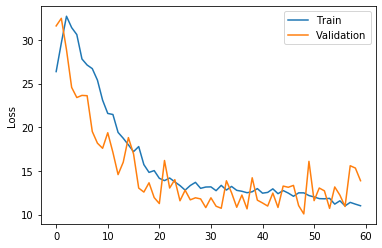

In [19]:
x_axis = range(0, num_epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, training_losses, label='Train')
ax.plot(x_axis, validation_losses, label='Validation')
ax.legend()
plt.ylabel('Loss')
plt.show()

# Show Results

In [20]:
from tqdm.notebook import tqdm, trange

model.eval()  # evaluation mode
batch_iter = tqdm(enumerate(val_loader), 'Validation', total=len(val_loader),
                    leave=False)

model_outputs = []
original_images = []
gts = []
dice_c0 = []
dice_c1 = []
dice_c2 = []
dice_c3 = []

for i, (x, y) in batch_iter:
    input, target = x.to(device), y.to(device)  # send to device (GPU or CPU)
    
    original_images.append(input.detach().clone())
    gts.append(target.detach().clone())
    
    with torch.no_grad():
        out = model(input)
        print(out.shape)
    
    out_soft = torch.argmax(out, dim=1) 
    model_outputs.append(out_soft)

    
    dice_c0.append(dice_score(out.detach().clone(), target, 0))
    dice_c1.append(dice_score(out.detach().clone(), target, 1))
    dice_c2.append(dice_score(out.detach().clone(), target, 2))
    dice_c3.append(dice_score(out.detach().clone(), target, 3))


batch_iter.close()

torch.Size([4, 4, 12, 200, 200])
torch.Size([4, 4, 12, 200, 200])
torch.Size([4, 4, 12, 200, 200])
torch.Size([4, 4, 12, 200, 200])


In [21]:
model_outputs = np.asarray(model_outputs)
original_images = np.asarray(original_images)
gts = np.asarray(gts)

In [22]:
model_outputs[0].shape, original_images[0].shape, gts[0].shape

(torch.Size([4, 12, 200, 200]),
 torch.Size([4, 1, 12, 200, 200]),
 torch.Size([4, 12, 200, 200]))

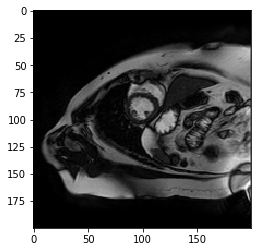

In [23]:
plt.imshow(original_images[0][2][0][6].cpu(), cmap='gray')

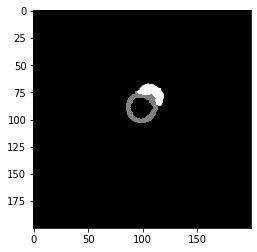

In [24]:
plt.imshow(gts[0][2][6].cpu(), cmap='gray')

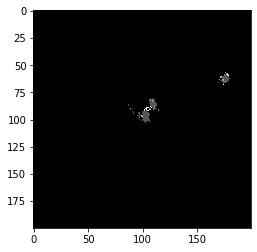

In [25]:
plt.imshow(model_outputs[0][2][6].cpu(), cmap='gray')

# Check

In [26]:
metadata[metadata['External code'] == 'A5C2D2']

,External code,VendorName,Vendor,Centre,ED,ES
22,A5C2D2,Philips,B,3,24,9


In [27]:
p = dataDir + 'Validation/A5C2D2/A5C2D2_sa_gt.nii.gz'
a = nib.load(p).get_fdata()

In [28]:
a.shape

(288, 288, 10, 25)

In [29]:
a = a[:,:,:, 24]

In [30]:
a = change_sizes(a, 0, True)
a = normalize_01(a)
a.shape

(12, 200, 200)

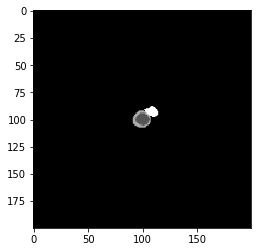

In [31]:
plt.imshow(a[2], cmap='gray')